# EXPLORING IMAGE CLASSIFICATION USING CNNs AND KERNEL METHODS

### Ho diviso il file nei rispettivi chunk di codice. Il dataset usato è CIFAR-10. Ho applicato data augmentation sul training set per avere diversità nel training e ridurre overfitting.

- **Parametri di regolarizzazione Res-Net**: dropout
- **Parametri di regolarizzazione SVM**: C
- **Parametri di regolarizzazione SVM con RFF**: C, $\gamma$


### Import Packages

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

### Data Pre-Processing and Data Augmentation

In [12]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


### Visualize Augmented and Default Data

In [13]:
# Function to denormalize an image
def denormalize(img):
    # Reverse the normalization using mean and std
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    # Clamp values to be in the range [0, 1] for valid image visualization
    return img.clamp(0, 1)


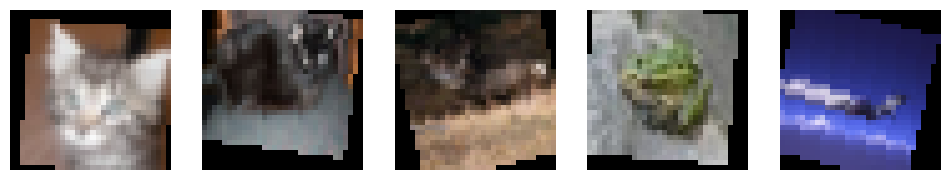

In [14]:
# Augmented Dataset
dataiter = iter(train_loader)  # Get a batch of training data
images, labels = next(dataiter)  # Extract images and labels from the batch

# Create a grid of 1x5 subplots for visualization
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
    img = denormalize(images[i])  # Denormalize the image
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert from CHW format to HWC format for plotting
    axes[i].imshow(img)  # Display the image
    axes[i].axis('off')  # Remove axis for cleaner visualization

plt.show()  # Display the plot

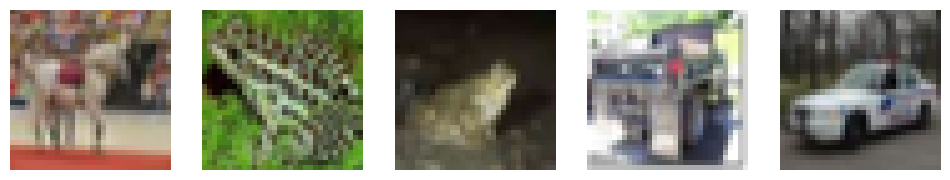

In [15]:
# Default Dataset
dataiter = iter(val_loader)  # Get a batch of training data
images, labels = next(dataiter)  # Extract images and labels from the batch

# Create a grid of 1x5 subplots for visualization
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
    img = denormalize(images[i])  # Denormalize the image
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert from CHW format to HWC format for plotting
    axes[i].imshow(img)  # Display the image
    axes[i].axis('off')  # Remove axis for cleaner visualization

plt.show()  # Display the plot

### Set device to GPU

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Resnet Architecture

In [17]:
# Dropout to be set
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, drop_rate=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,drop_rate=0.1):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=drop_rate) #second dropout before fc layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

### Choose the model:
- Resnet-18 
- Resnet-34

In [18]:
# Models from scratch
resnet18_from_scratch = ResNet18(num_classes=10) 
resnet34_from_scratch = ResNet34(num_classes=10)
# set the chosen model
model = resnet18_from_scratch.to(device)  
# show the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

## ResNet + Softmax

In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/50:
Train Loss: 1.5136, Train Acc: 44.50%
Val Loss: 1.2112, Val Acc: 57.39%
Epoch 2/50:
Train Loss: 1.1679, Train Acc: 58.22%
Val Loss: 1.0043, Val Acc: 64.83%
Epoch 3/50:
Train Loss: 1.0020, Train Acc: 64.47%
Val Loss: 0.8835, Val Acc: 68.68%
Epoch 4/50:
Train Loss: 0.9004, Train Acc: 68.48%
Val Loss: 0.8118, Val Acc: 71.98%
Epoch 5/50:
Train Loss: 0.8169, Train Acc: 71.33%
Val Loss: 0.6715, Val Acc: 76.72%
Epoch 6/50:
Train Loss: 0.7509, Train Acc: 73.80%
Val Loss: 0.7546, Val Acc: 74.79%
Epoch 7/50:
Train Loss: 0.7067, Train Acc: 75.42%
Val Loss: 0.6173, Val Acc: 78.76%
Epoch 8/50:
Train Loss: 0.6647, Train Acc: 76.86%
Val Loss: 0.5874, Val Acc: 80.18%
Epoch 9/50:
Train Loss: 0.6303, Train Acc: 78.23%
Val Loss: 0.5788, Val Acc: 79.87%
Epoch 10/50:
Train Loss: 0.6027, Train Acc: 78.98%
Val Loss: 0.5484, Val Acc: 81.03%
Epoch 11/50:
Train Loss: 0.5719, Train Acc: 79.96%
Val Loss: 0.5880, Val Acc: 80.30%
Epoch 12/50:
Train Loss: 0.5503, Train Acc: 80.98%
Val Loss: 0.5445, Val A

In [20]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.4100, Test Accuracy: 88.25%


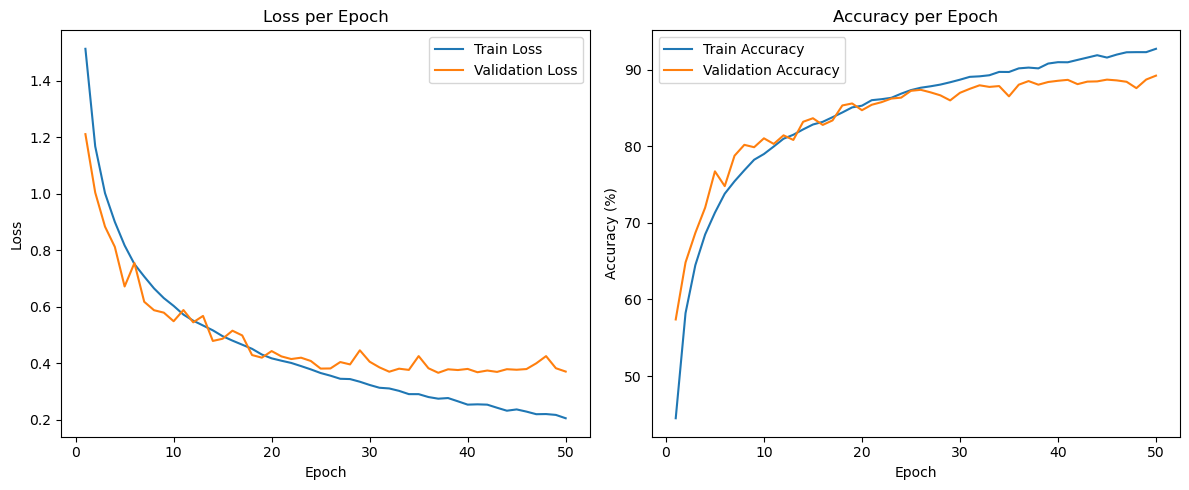

In [21]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## ResNet+ SVM end-to-end

#### Replace the cross entropy loss with the Square Hinge Loss

In [22]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C=10):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


In [23]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc.weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc.weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/50:
Train Loss: 2.9480, Train Acc: 42.17%
Val Loss: 2.3743, Val Acc: 57.50%
Epoch 2/50:
Train Loss: 2.3185, Train Acc: 57.23%
Val Loss: 2.1720, Val Acc: 61.28%
Epoch 3/50:
Train Loss: 2.0008, Train Acc: 63.67%
Val Loss: 1.6350, Val Acc: 70.94%
Epoch 4/50:
Train Loss: 1.7945, Train Acc: 67.92%
Val Loss: 1.5871, Val Acc: 72.57%
Epoch 5/50:
Train Loss: 1.6536, Train Acc: 70.66%
Val Loss: 1.4759, Val Acc: 74.43%
Epoch 6/50:
Train Loss: 1.5274, Train Acc: 73.27%
Val Loss: 1.3247, Val Acc: 76.71%
Epoch 7/50:
Train Loss: 1.4400, Train Acc: 74.65%
Val Loss: 1.2234, Val Acc: 78.51%
Epoch 8/50:
Train Loss: 1.3414, Train Acc: 76.71%
Val Loss: 1.3181, Val Acc: 77.65%
Epoch 9/50:
Train Loss: 1.2909, Train Acc: 77.84%
Val Loss: 1.2109, Val Acc: 79.58%
Epoch 10/50:
Train Loss: 1.2283, Train Acc: 78.88%
Val Loss: 1.1664, Val Acc: 79.94%
Epoch 11/50:
Train Loss: 1.1820, Train Acc: 79.71%
Val Loss: 1.1135, Val Acc: 80.79%
Epoch 12/50:
Train Loss: 1.1334, Train Acc: 80.48%
Val Loss: 1.0403, Val A

In [24]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7421, Test Accuracy: 88.10%


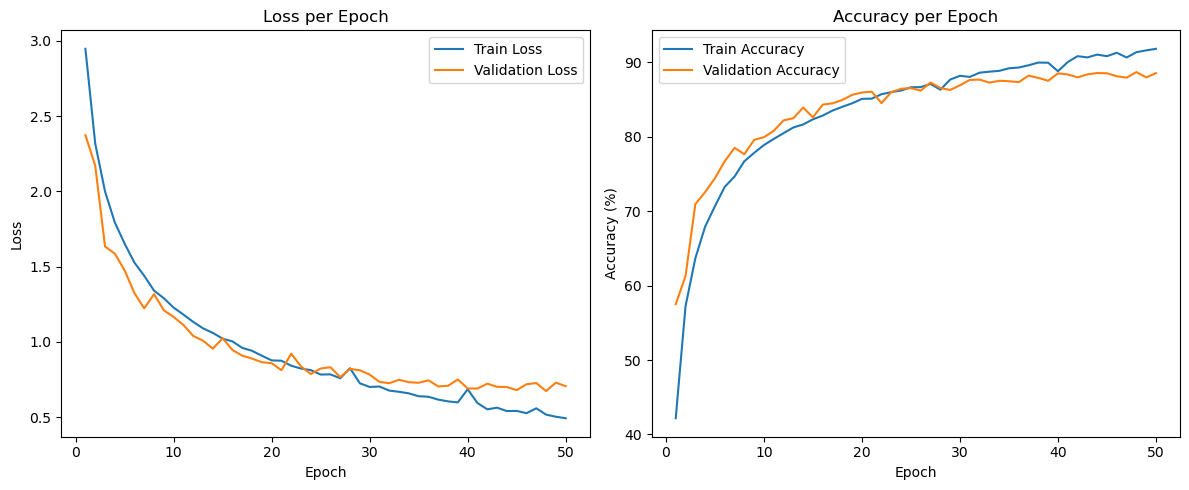

In [25]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## ResNet-34 + Kernel SVM end-to-end using Random Fourier Features

#### Define the class fot the RFF transformations

In [26]:
class RandomFourierFeatures(nn.Module):
    def __init__(self, input_dim, sigma=1):
        super(RandomFourierFeatures, self).__init__()
        self.input_dim = input_dim  # Input dimension
        self.scale = sigma  # Scale factor for the weights
        
        # Fixed weights for RFF: a vector of 512 weights
        self.register_buffer("weights", torch.normal(mean=0, std=torch.sqrt(torch.tensor(sigma)), size=(input_dim,)))  # Vector of weights
        self.register_buffer("bias", 2 * np.pi * torch.rand(input_dim))  # Random biases for RFF

    def forward(self, x):
        # Element-wise multiplication of input x with the weight vector
        projections = x * self.weights  # Element-wise multiplication
        
        # Add the bias term
        projections = projections + self.bias  # Add bias to the projection
        
        # Apply the cosine transformation
        projections = torch.cos(projections)  # Apply cosine function
        
        # Multiply by sqrt(2 / D), where D is the input dimension (input_dim)
        return torch.sqrt(torch.tensor(2.0 / self.input_dim)) * projections

#### Modify the CNN architecture

In [27]:
# Load the default ResNet34 model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device

# Extract the embedding dimension from ResNet (which is 512 for ResNet34)
embedding_dim = model.fc.in_features  # Number of features in the fully connected layer

# Define RFF layer, ensuring the output dimension is the same as the input dimension
rff_layer = RandomFourierFeatures(embedding_dim)

# Replace the fully connected layer with a custom sequence (dropout, RFF, final linear layer)
model.fc = nn.Sequential(
    rff_layer,  # Apply Random Fourier Features
    nn.Linear(embedding_dim, 10)  # Final classification layer (10 output classes)
)

# Move the model to the correct device (GPU or CPU)
model = model.to(device)

In [28]:
# Square hinge loss as defined earlier
def square_hinge_loss(outputs, targets, weights, C=10):
    # Convert targets to one-hot encoding
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # Initialize with -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1

    # Compute the margins
    margins = 1 - targets_one_hot * outputs
    hinge_loss = torch.clamp(margins, min=0) ** 2  # Apply squared hinge loss
    hinge_loss = hinge_loss.mean()  # Take the mean over all samples and classes

    # Compute the L2 regularization loss (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    
    # Total loss including the regularization term
    total_loss = C * hinge_loss + reg_loss

    return total_loss



# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters())  
# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step

        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight

        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)
            
            # Get weights of the final layer
            readout_weights = model.fc[-1].weight
            
            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/50:
Train Loss: 3.4762, Train Acc: 27.71%
Val Loss: 2.8363, Val Acc: 44.84%
Epoch 2/50:
Train Loss: 2.6163, Train Acc: 48.72%
Val Loss: 2.3855, Val Acc: 54.66%
Epoch 3/50:
Train Loss: 2.2463, Train Acc: 57.30%
Val Loss: 2.2531, Val Acc: 57.84%
Epoch 4/50:
Train Loss: 2.0180, Train Acc: 62.18%
Val Loss: 1.7553, Val Acc: 67.44%
Epoch 5/50:
Train Loss: 1.8466, Train Acc: 65.88%
Val Loss: 1.6757, Val Acc: 69.40%
Epoch 6/50:
Train Loss: 1.7325, Train Acc: 68.32%
Val Loss: 1.5454, Val Acc: 72.00%
Epoch 7/50:
Train Loss: 1.6034, Train Acc: 70.97%
Val Loss: 1.5470, Val Acc: 71.66%
Epoch 8/50:
Train Loss: 1.5016, Train Acc: 73.19%
Val Loss: 1.4322, Val Acc: 74.34%
Epoch 9/50:
Train Loss: 1.4249, Train Acc: 74.66%
Val Loss: 1.2643, Val Acc: 77.97%
Epoch 10/50:
Train Loss: 1.3586, Train Acc: 75.88%
Val Loss: 1.2224, Val Acc: 78.32%
Epoch 11/50:
Train Loss: 1.3074, Train Acc: 76.81%
Val Loss: 1.2791, Val Acc: 77.29%
Epoch 12/50:
Train Loss: 1.2590, Train Acc: 77.83%
Val Loss: 1.0832, Val A

In [29]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7766, Test Accuracy: 87.11%


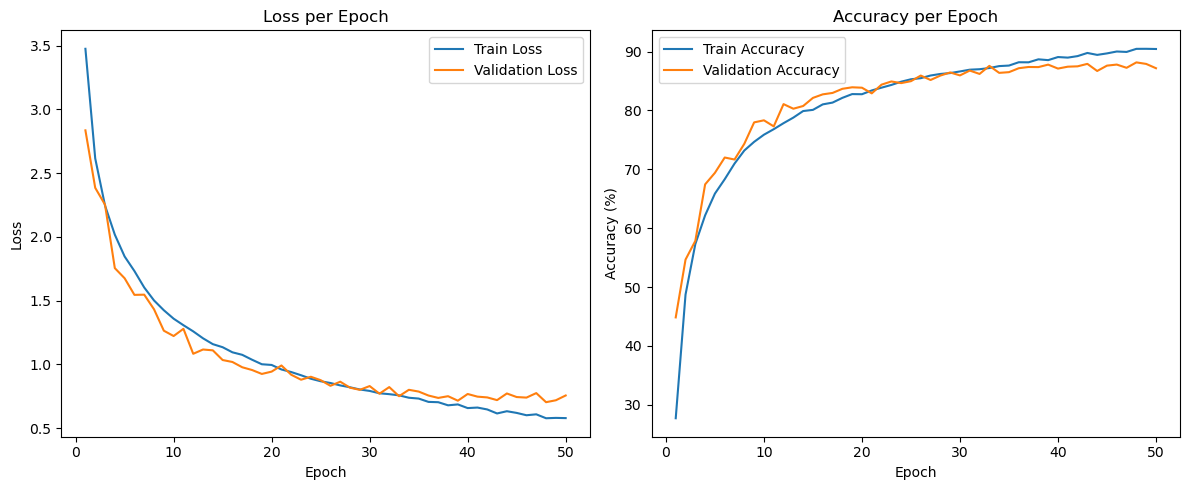

In [30]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

prova con normalizzazione

In [31]:
# Dropout to be set
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, drop_rate=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,drop_rate=0.1):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.layer_norm = nn.LayerNorm(512)
        self.fc_dropout = nn.Dropout(p=drop_rate) #second dropout before fc layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer_norm(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [32]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C=10):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


In [33]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc.weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc.weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 1/50:
Train Loss: 3.1379, Train Acc: 41.60%
Val Loss: 2.7735, Val Acc: 49.57%
Epoch 2/50:
Train Loss: 2.4134, Train Acc: 55.35%
Val Loss: 2.3767, Val Acc: 57.42%
Epoch 3/50:
Train Loss: 2.0936, Train Acc: 62.03%
Val Loss: 1.7941, Val Acc: 68.48%
Epoch 4/50:
Train Loss: 1.8720, Train Acc: 66.81%
Val Loss: 1.9665, Val Acc: 68.13%
Epoch 5/50:
Train Loss: 1.7116, Train Acc: 70.08%
Val Loss: 1.5363, Val Acc: 73.59%
Epoch 6/50:
Train Loss: 1.6051, Train Acc: 72.13%
Val Loss: 1.4227, Val Acc: 75.24%
Epoch 7/50:
Train Loss: 1.5165, Train Acc: 73.89%
Val Loss: 1.3410, Val Acc: 76.86%
Epoch 8/50:
Train Loss: 1.4395, Train Acc: 75.30%
Val Loss: 1.2617, Val Acc: 79.09%
Epoch 9/50:
Train Loss: 1.3492, Train Acc: 76.84%
Val Loss: 1.1558, Val Acc: 79.97%
Epoch 10/50:
Train Loss: 1.3084, Train Acc: 77.62%
Val Loss: 1.1447, Val Acc: 80.31%
Epoch 11/50:
Train Loss: 1.2489, Train Acc: 78.78%
Val Loss: 1.2273, Val Acc: 79.05%
Epoch 12/50:
Train Loss: 1.2171, Train Acc: 79.38%
Val Loss: 1.1211, Val A

TypeError: validate() takes 2 positional arguments but 3 were given

torna resnet normale ma con train a 90%

In [34]:
# Dropout to be set
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, drop_rate=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,drop_rate=0.1):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=drop_rate) #second dropout before fc layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [35]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.9 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 45000
Val set size: 5000
Test set size: 10000


In [36]:
resnet34_from_scratch = ResNet34(num_classes=10)
# set the chosen model
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch 1/50:
Train Loss: 0.3163, Train Acc: 90.56%
Val Loss: 0.3708, Val Acc: 88.42%
Epoch 2/50:
Train Loss: 0.2753, Train Acc: 91.20%
Val Loss: 0.4024, Val Acc: 87.56%
Epoch 3/50:
Train Loss: 0.2702, Train Acc: 91.18%
Val Loss: 0.3476, Val Acc: 88.96%
Epoch 4/50:
Train Loss: 0.2643, Train Acc: 91.20%
Val Loss: 0.3482, Val Acc: 88.76%
Epoch 5/50:
Train Loss: 0.2566, Train Acc: 91.66%
Val Loss: 0.3216, Val Acc: 89.48%
Epoch 6/50:
Train Loss: 0.2468, Train Acc: 91.85%
Val Loss: 0.3468, Val Acc: 89.14%
Epoch 7/50:
Train Loss: 0.2431, Train Acc: 92.05%
Val Loss: 0.3393, Val Acc: 88.98%
Epoch 8/50:
Train Loss: 0.2374, Train Acc: 92.14%
Val Loss: 0.3276, Val Acc: 89.80%
Epoch 9/50:
Train Loss: 0.2322, Train Acc: 92.18%
Val Loss: 0.3322, Val Acc: 89.12%
Epoch 10/50:
Train Loss: 0.2278, Train Acc: 92.38%
Val Loss: 0.3428, Val Acc: 89.08%
Epoch 11/50:
Train Loss: 0.2195, Train Acc: 92.80%
Val Loss: 0.3618, Val Acc: 88.86%
Epoch 12/50:
Train Loss: 0.2161, Train Acc: 92.88%
Val Loss: 0.3425, Val A